# Explore example datasets

We provide the option to download subsets of existing open datasets with opportunistic sensor data. In this notebook we present these datasets and their subsets.

In [1]:
import poligrain as plg

In [7]:
(
    ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi,
) = plg.example_data.load_openmrg(data_dir="example_data", subset="8d")

File already exists at example_data/openmrg_cml_8d.nc
Not downloading!
File already exists at example_data/openmrg_rad_8d.nc
Not downloading!
File already exists at example_data/openmrg_municp_gauge_8d.nc
Not downloading!
File already exists at example_data/openmrg_smhi_gauge_8d.nc
Not downloading!


<Axes: xlabel='lon', ylabel='lat'>

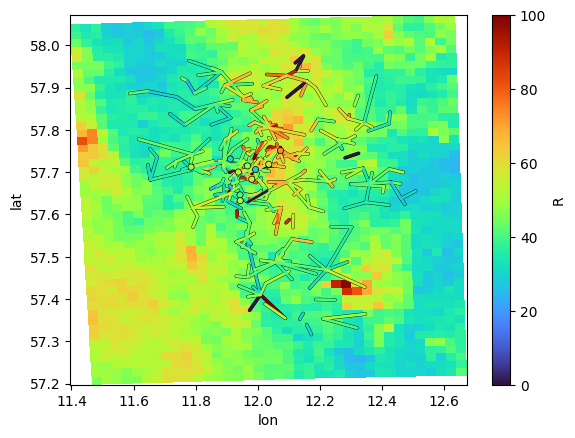

In [8]:
plg.plot_map.plot_plg(
    da_cmls=ds_cmls.isel(sublink_id=0).R.resample(time="1h").mean().sum(dim="time"),
    da_grid=ds_rad.R.resample(time="1h").mean().sum(dim="time"),
    da_gauges=ds_gauges_municp.rainfall_amount.sum(dim="time"),
    vmin=0,
    vmax=100,
)